<a href="https://colab.research.google.com/github/ssvadla/Demonstration/blob/main/SemiSupervised_undersampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Semi Supervised Approach with unlabelled dataset
Downsampling with the Randomundersampler

In [ ]:
import pandas as pd
from google.colab import drive
from collections import Counter

drive.mount('/content/drive')

train = pd.read_csv('/content/drive/My Drive/Research/train_data1.csv')
train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,Sentence,Target
0,659,Appellant had stated to the officers that she ...,Invalid
1,3456,We shall discuss the facts more fully in conne...,Others
2,2043,"â€œPerjury is a false statement, either writte...",Invalid
3,3344,The offense is felony theft by false pretext; ...,Issue
4,3231,Numerous contentions urging the commission of ...,Issue


In [ ]:
train['Target'].unique()

array(['Invalid', 'Others', 'Issue', 'Analysis', 'Facts', 'Conclusion',
       'Rule/Law/Holding'], dtype=object)

In [ ]:
train['Target']=train['Target'].replace(['Others'],'Invalid')
train['Target'].unique()

array(['Invalid', 'Issue', 'Analysis', 'Facts', 'Conclusion',
       'Rule/Law/Holding'], dtype=object)

Class=3, n=550 (15.823%)
Class=4, n=218 (6.272%)
Class=0, n=520 (14.960%)
Class=2, n=1769 (50.892%)
Class=1, n=179 (5.150%)
Class=5, n=240 (6.904%)


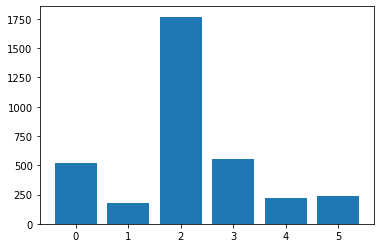

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
data = train.values


# split into input and output elements
X, y = data[:, :-1], data[:, -1]
# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
#cleaning
import nltk
import re
import string
nltk.download('stopwords')
nltk.download('wordnet')
stopword=nltk.corpus.stopwords.words('english')
from nltk.stem import WordNetLemmatizer
wl= WordNetLemmatizer()

def clean_text(text):
  text="".join([word.lower() for word in text if word not in string.punctuation])
  tokens = re.split('\W+',text)
  text = [wl.lemmatize(word) for word in tokens if word not in stopword]
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer = clean_text)
X_tfidf = tfidf_vect.fit_transform(train['Sentence'])
print(X_tfidf.shape)

(3476, 6383)


In [ ]:
X_tfidf_df=pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns=tfidf_vect.get_feature_names()
X_tfidf_df.head()

,,015,1,10,100,1000,10000,100000,10000000,1008,1008a,101,1013,1015,102,1026,104,1044,105,1065,107,107c,1081,1084,1097,10a,10acre,11,110,1102,111,1116,112,113,1130,113637,1140,114073,115,1150,...,œsuccessively,œswayingâ,œswollenâ,œtesting,œtestâ,œthat,œthatâ,œthe,œthere,œthey,œthick,œthis,œto,œtwo,œtwoâ,œunlawfully,œunlawfullyâ,œupon,œvagrancyâ,œvalue,œvery,œvisited,œwaived,œwalked,œwas,œwater,œwe,œwell,œwhat,œwhen,œwhere,œwhile,œwhoever,œwilfullyâ,œwillfullyâ,œwobblyâ,œyes,œyesâ,œyou,œyour
0,0.136318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Class=Analysis, n=179 (16.667%)
Class=Conclusion, n=179 (16.667%)
Class=Facts, n=179 (16.667%)
Class=Invalid, n=179 (16.667%)
Class=Issue, n=179 (16.667%)
Class=Rule/Law/Holding, n=179 (16.667%)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


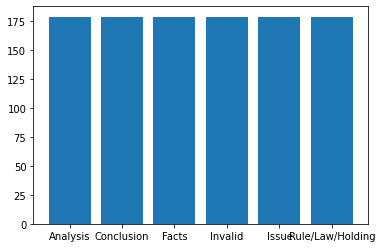

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

undersampling_Dict={'Facts': 179, 'Invalid': 179, 'Analysis': 179, 'Rule/Law/Holding': 179, 'Issue': 179, 'Conclusion': 179}
oversample = SMOTE("minority")
undersample = RandomUnderSampler(sampling_strategy=undersampling_Dict)
#X, y = oversample.fit_sample(X_tfidf_df, train['Target'])
X, y = undersample.fit_resample(X_tfidf_df, train['Target'])
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()



In [ ]:
test = pd.read_csv(r'/content/drive/My Drive/Research/test_data.csv')

test['Target']=test['Target'].replace(['Others'],'Invalid')
test['Sentence'] = test['Sentence'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
test['Sentence'] = test['Sentence'].str.replace('[^\w\s]','')
from nltk.corpus import stopwords
words = stopwords.words('english')
test['Sentence'] = test['Sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in words))
t_p = tfidf_vect.transform(test['Sentence'])

In [ ]:
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



#X, y = make_classification(random_state=1)
counter = Counter(y)
print(counter)
#X_train, x_val, Y_train, y_val = train_test_split(X_tfidf,train['Target'],test_size=0.26,random_state=42)
X_train, x_val, Y_train, y_val = train_test_split(X,y,test_size=0.26,random_state=42)

classifier = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42)
classifier.fit(X_train, Y_train)
y_pred = classifier.predict(x_val)
#print(np.unique(y_pred))
#print(type(y_pred))

Accuracy_score = accuracy_score(y_pred,y_val)

print('Validation Accuracy_score: %f' % Accuracy_score)
test_pred = classifier.predict(t_p)
acc_test = accuracy_score(test_pred,test['Target'])
print('Accuracy test data', acc_test)
matrix = confusion_matrix(y_pred, y_val)
print(matrix)


Counter({'Analysis': 179, 'Conclusion': 179, 'Facts': 179, 'Invalid': 179, 'Issue': 179, 'Rule/Law/Holding': 179})
Validation Accuracy_score: 0.485714
Accuracy test data 0.45681381957773515
[[12  6  2  2  4  6]
 [ 6 31  0  1  2  3]
 [ 7  2 23  5  1  3]
 [11 10 21 34  7 15]
 [ 7  3  2  3 22  6]
 [ 1  1  1  3  3 14]]


In [ ]:

unlabel = pd.read_csv(r'/content/drive/My Drive/Research/Unlabeled_data.csv')
unlabel.head()


,Unnamed: 0,text,Complete
0,0,No motion for rehearing filed.,1
1,1,— Relator is under accusation of killing her h...,1
2,2,From an order of the District Judge of the 39t...,1
3,3,Relator and her husband had been married for a...,1
4,4,The evidence indicates that their family relat...,1


In [ ]:
del unlabel['Complete']

In [ ]:
del unlabel['Unnamed: 0']

In [ ]:
unlabel.head()

,text
0,No motion for rehearing filed.
1,— Relator is under accusation of killing her h...
2,From an order of the District Judge of the 39t...
3,Relator and her husband had been married for a...
4,The evidence indicates that their family relat...


In [ ]:
unlabel['text'] = unlabel['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
unlabel['text'] = unlabel['text'].str.replace('[^\w\s]','')
from nltk.corpus import stopwords
words = stopwords.words('english')
unlabel['text'] = unlabel['text'].apply(lambda x: " ".join(x for x in x.split() if x not in words))


In [ ]:
from textblob import TextBlob
from textblob import Word
nltk.download('wordnet')
nltk.download('punkt')
unlabel['text'] = unlabel['text'].apply(lambda x: TextBlob(x).words)
unlabel['text'] = unlabel['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
unlabel.head()

,text
0,motion rehearing filed
1,relator accusation killing husband virgil clark
2,order district judge 39th judicial district re...
3,relator husband married number year
4,evidence indicates family relation always plea...


In [ ]:
len(unlabel)

537703

In [ ]:
unlabel_1 = unlabel.loc[:100000]
print("length of unlabel_1",len(unlabel_1))
unlabel_2 = unlabel.loc[100001:200000]
print("length of unlabel_2",len(unlabel_2))
unlabel_3 = unlabel.loc[200001:300000]
print("length of unlabel_3",len(unlabel_3))
unlabel_4 = unlabel.loc[300001:400000]
print("length of unlabel_4",len(unlabel_4))
unlabel_5 = unlabel.loc[400001:]
print("length of unlabel_5",len(unlabel_5))

length of unlabel_1 100001
length of unlabel_2 100000
length of unlabel_3 100000
length of unlabel_4 100000
length of unlabel_5 137702


In [ ]:
unlabel_1.head()

,text
0,motion rehearing filed
1,relator accusation killing husband virgil clark
2,order district judge 39th judicial district re...
3,relator husband married number year
4,evidence indicates family relation always plea...


In [ ]:
unlabel_2.reset_index(inplace=True)
del unlabel_2['index']
unlabel_2.head()

,text
0,responding conclusion regarding evidence annou...
1,conviction transporting intoxicating liquor pu...
2,bill exception case filed late
3,motion new trial overruled october 22 1927 ord...
4,thereafter december 10th extension order made ...


In [ ]:
unlabel_3.reset_index(inplace=True)
del unlabel_3['index']
unlabel_3.head()

,text
0,another man carrying clothes
1,officer testified appellant several item cloth...
2,investigation followed report breaking entry a...
3,appellant present
4,warrant arrest issued officer went hotel waite...


In [ ]:
unlabel_4.reset_index(inplace=True)
del unlabel_4['index']
unlabel_4.head()

,text
0,statute final judgment appeal court lie senten...
1,sentence must pronounced term court judgment r...
2,court sentence defendant vacation
3,court adjourned authority case ceased notice a...
4,pronouncing sentence authorized vacation autho...


In [ ]:
unlabel_5.reset_index(inplace=True)
del unlabel_5['index']
unlabel_5.head()

,text
0,member federal reserve bank
1,opinion state case
2,conviction violating state cigarette law punis...
3,find record bill exception bringing forward co...
4,brief appellant complains lack testimony


In [ ]:
classifier.classes_

array(['Analysis', 'Conclusion', 'Facts', 'Invalid', 'Issue',
       'Rule/Law/Holding'], dtype=object)

In [ ]:
x_un1 = tfidf_vect.transform(unlabel_1['text'])


In [ ]:
x_un1.shape
pred_unlabel_1 = classifier.predict_proba(x_un1)
pred_unlabel_1



array([[0.01, 0.44, 0.1 , 0.4 , 0.01, 0.04],
       [0.  , 0.13, 0.  , 0.8 , 0.07, 0.  ],
       [0.07, 0.07, 0.08, 0.43, 0.18, 0.17],
       ...,
       [0.2 , 0.09, 0.39, 0.11, 0.14, 0.07],
       [0.28, 0.02, 0.28, 0.36, 0.01, 0.05],
       [0.31, 0.01, 0.18, 0.42, 0.06, 0.02]])

In [ ]:
print(len(pred_unlabel_1))
print(np.unique(pred_unlabel_1))


100001
[0.         0.00333333 0.005      0.00833333 0.01       0.01333333
 0.015      0.01666667 0.01833333 0.02       0.02166667 0.02333333
 0.02333333 0.025      0.02666667 0.0275     0.02833333 0.03
 0.03166667 0.0325     0.03333333 0.035      0.035      0.03583333
 0.03666667 0.03833333 0.03833333 0.04       0.04083333 0.04166667
 0.04333333 0.04333333 0.045      0.045      0.04666667 0.04666667
 0.04833333 0.04833333 0.04916667 0.05       0.05083333 0.05166667
 0.05166667 0.05333333 0.05333333 0.055      0.055      0.055
 0.05666667 0.05666667 0.05833333 0.05833333 0.06       0.06
 0.06166667 0.06166667 0.06333333 0.06333333 0.065      0.06666667
 0.06833333 0.06833333 0.07       0.07166667 0.07166667 0.0725
 0.07333333 0.075      0.07666667 0.07666667 0.07733333 0.07833333
 0.07833333 0.07845238 0.08       0.08166667 0.08166667 0.08261905
 0.08333333 0.08333333 0.085      0.086      0.08666667 0.08666667
 0.08733333 0.08733333 0.08816667 0.08833333 0.08833333 0.089
 0.09       0.

In [ ]:
Threshold= 0.98

In [ ]:
import numpy as np
pos=[]
large=[]
ind = []
i=0
for j in pred_unlabel_1:
  if max(j)> Threshold:
    ind.append(np.argmax(j))
    large.append(max(j))
    pos.append(i)
  i+=1


print(ind)
print(large)
print(pos)
print(type(pos))
print(len(ind))
print(len(large))
print(len(pos))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[2584, 5233, 6000, 6585, 6954, 8638, 15343, 16617, 17414, 20458, 20858, 28175, 31001, 31394, 32913, 35388, 36790, 36834, 41891, 42139, 44934, 45210, 45421, 46121, 46640, 48160, 52129, 53297, 54291, 55546, 58561, 59179, 59503, 60136, 61339, 62229, 65441, 66114, 67256, 70578, 72866, 77200, 77879, 78607, 78939, 79359, 81083, 82946, 83884, 85181, 86001, 86669, 87873, 92631, 93246, 97671, 97945, 98517]
<class 'list'>
58
58
58


In [ ]:
unlabel_1 = unlabel_1.loc[pos,:]
print(len(unlabel_1))
unlabel_1.head()

58


,text
2584,error pointed judgment reversed cause remanded
5233,error pointed judgment reversed cause remanded
6000,error pointed judgment reversed cause remanded
6585,error pointed judgment reversed cause remanded
6954,error pointed judgment reversed cause remanded


In [ ]:
class_x_un1 = tfidf_vect.transform(unlabel_1['text'])

In [ ]:
class_x_un1.shape

(58, 6383)

In [ ]:

class_pred_unlabel_1 = classifier.predict(class_x_un1)
class_pred_unlabel_1


array(['Conclusion', 'Conclusion', 'Conclusion', 'Conclusion',
       'Conclusion', 'Conclusion', 'Conclusion', 'Conclusion',
       'Conclusion', 'Conclusion', 'Conclusion', 'Conclusion',
       'Conclusion', 'Conclusion', 'Conclusion', 'Conclusion',
       'Conclusion', 'Conclusion', 'Conclusion', 'Conclusion',
       'Conclusion', 'Conclusion', 'Invalid', 'Conclusion', 'Conclusion',
       'Conclusion', 'Conclusion', 'Conclusion', 'Conclusion',
       'Conclusion', 'Conclusion', 'Conclusion', 'Conclusion',
       'Conclusion', 'Conclusion', 'Conclusion', 'Conclusion',
       'Conclusion', 'Conclusion', 'Conclusion', 'Conclusion',
       'Conclusion', 'Conclusion', 'Conclusion', 'Conclusion',
       'Conclusion', 'Conclusion', 'Conclusion', 'Conclusion',
       'Conclusion', 'Conclusion', 'Conclusion', 'Conclusion',
       'Conclusion', 'Conclusion', 'Conclusion', 'Conclusion',
       'Conclusion'], dtype=object)

In [ ]:
print(len(class_pred_unlabel_1))

58


In [ ]:
unlabel_1['Target']=class_pred_unlabel_1
unlabel_1.head()

,text,Target
2584,error pointed judgment reversed cause remanded,Conclusion
5233,error pointed judgment reversed cause remanded,Conclusion
6000,error pointed judgment reversed cause remanded,Conclusion
6585,error pointed judgment reversed cause remanded,Conclusion
6954,error pointed judgment reversed cause remanded,Conclusion


In [ ]:
train = train.rename(columns={'Sentence':'text'})
train.head()

,Unnamed: 0,text,Target
0,659,Appellant had stated to the officers that she ...,Invalid
1,3456,We shall discuss the facts more fully in conne...,Invalid
2,2043,"â€œPerjury is a false statement, either writte...",Invalid
3,3344,The offense is felony theft by false pretext; ...,Issue
4,3231,Numerous contentions urging the commission of ...,Issue


In [ ]:
frame_1 = [train,unlabel_1]
train_1 = pd.concat(frame_1)
print(len(train))
print(len(unlabel_1))
print(len(train_1))

3476
58
3534


In [ ]:
from sklearn.metrics import classification_report
x_train_1 = tfidf_vect.transform(train_1['text'])
x_train_1.shape
X_train, x_val, Y_train, y_val = train_test_split(x_train_1,train_1['Target'],test_size=0.25,random_state=2)
classifier_1 = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42)
classifier_1.fit(X_train, Y_train)
y_pred = classifier_1.predict(x_val)
print(np.unique(y_pred))
print(type(y_pred))


Accuracy_score = accuracy_score(y_pred,y_val)

print('Validation ------- Accuracy_score: %f' % Accuracy_score)

test_pred = classifier_1.predict(t_p)
acc_test = accuracy_score(test_pred,test['Target'])
print('Test ------Accuracy score ', acc_test)
matrix = confusion_matrix(y_pred, y_val)
print(matrix)
print("---------validation--------------")
print(classification_report(y_val,y_pred))
print("----------test---------------------")
print(classification_report(test['Target'],test_pred))

['Analysis' 'Conclusion' 'Facts' 'Invalid' 'Issue' 'Rule/Law/Holding']
<class 'numpy.ndarray'>
Validation ------- Accuracy_score: 0.631222
Test ------Accuracy score  0.6257197696737045
[[ 40   8  18   9   3   6]
 [  3  28   0   1   1   0]
 [ 80  16 381  52  25  29]
 [ 12   6  29  77   2  12]
 [  1   0   3   2  15   0]
 [  1   0   0   2   5  17]]
---------validation--------------
                  precision    recall  f1-score   support

        Analysis       0.48      0.29      0.36       137
      Conclusion       0.85      0.48      0.62        58
           Facts       0.65      0.88      0.75       431
         Invalid       0.56      0.54      0.55       143
           Issue       0.71      0.29      0.42        51
Rule/Law/Holding       0.68      0.27      0.38        64

        accuracy                           0.63       884
       macro avg       0.66      0.46      0.51       884
    weighted avg       0.63      0.63      0.60       884

----------test---------------------

Second set of unlabeled data 

In [ ]:
x_un2 = tfidf_vect.transform(unlabel_2['text'])


In [ ]:

pred_unlabel_2 = classifier_1.predict_proba(x_un2)
pred_unlabel_2

array([[0.19166667, 0.45833333, 0.235     , 0.105     , 0.        ,
        0.01      ],
       [0.04      , 0.06      , 0.2       , 0.08      , 0.27      ,
        0.35      ],
       [0.06      , 0.06      , 0.5       , 0.3       , 0.01      ,
        0.07      ],
       ...,
       [0.01      , 0.        , 0.79      , 0.18      , 0.        ,
        0.02      ],
       [0.06      , 0.04      , 0.64      , 0.23      , 0.        ,
        0.03      ],
       [0.01      , 0.        , 0.99      , 0.        , 0.        ,
        0.        ]])

In [ ]:
print(len(pred_unlabel_2))
print(np.unique(pred_unlabel_2))

100000
[0.         0.00285714 0.00333333 ... 0.98       0.99       1.        ]


In [ ]:
import numpy as np
pos=[]
large=[]
ind = []
i=0
for j in pred_unlabel_2:
  if max(j)> Threshold:
    ind.append(np.argmax(j))
    large.append(max(j))
    pos.append(i)
  i+=1


print(ind)
print(large)
print(pos)
print(type(pos))
print(len(ind))
print(len(large))
print(len(pos))

[2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 3, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2]
[1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 0.99, 1.0, 0.99, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 0.99, 0.99, 1.0, 1.0, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 0.99, 0.99, 0.99, 1.0, 0.99, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.99, 1.0, 0.99, 1.0, 0.99, 0.99, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9

In [ ]:
unlabel_2 = unlabel_2.loc[pos,:]
print(len(unlabel_2))
unlabel_2.head()

199


,text
944,isaac allen went appellant told wanted get whi...
1100,appellant left hotel went garage vicinity stat...
1219,waiting deceased went adjoining room got pisto...
1757,error pointed judgment reversed cause remanded
2509,witness smith testified left picture show nigh...


In [ ]:
class_x_un2 = tfidf_vect.transform(unlabel_2['text'])

In [ ]:
class_x_un1.shape

(58, 6383)

In [ ]:
class_pred_unlabel_2 = classifier_1.predict(class_x_un2)
class_pred_unlabel_2

array(['Facts', 'Facts', 'Facts', 'Conclusion', 'Facts', 'Conclusion',
       'Facts', 'Conclusion', 'Conclusion', 'Facts', 'Facts',
       'Conclusion', 'Conclusion', 'Facts', 'Conclusion', 'Facts',
       'Conclusion', 'Conclusion', 'Facts', 'Facts', 'Facts', 'Facts',
       'Facts', 'Conclusion', 'Facts', 'Facts', 'Conclusion',
       'Conclusion', 'Facts', 'Facts', 'Conclusion', 'Conclusion',
       'Conclusion', 'Invalid', 'Facts', 'Conclusion', 'Facts', 'Facts',
       'Facts', 'Facts', 'Facts', 'Facts', 'Conclusion', 'Facts',
       'Conclusion', 'Facts', 'Facts', 'Facts', 'Conclusion', 'Facts',
       'Facts', 'Facts', 'Conclusion', 'Facts', 'Conclusion', 'Facts',
       'Facts', 'Facts', 'Conclusion', 'Facts', 'Facts', 'Facts',
       'Conclusion', 'Facts', 'Facts', 'Facts', 'Facts', 'Conclusion',
       'Conclusion', 'Conclusion', 'Facts', 'Facts', 'Facts',
       'Conclusion', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts',
       'Facts', 'Facts', 'Conclusion', 'Facts

In [ ]:
print(len(class_pred_unlabel_2))

199


In [ ]:
unlabel_2['Target']=class_pred_unlabel_2
unlabel_2.head()

,text,Target
944,isaac allen went appellant told wanted get whi...,Facts
1100,appellant left hotel went garage vicinity stat...,Facts
1219,waiting deceased went adjoining room got pisto...,Facts
1757,error pointed judgment reversed cause remanded,Conclusion
2509,witness smith testified left picture show nigh...,Facts


In [ ]:
train_1.head()

,Unnamed: 0,text,Target
0,659.0,Appellant had stated to the officers that she ...,Invalid
1,3456.0,We shall discuss the facts more fully in conne...,Invalid
2,2043.0,"â€œPerjury is a false statement, either writte...",Invalid
3,3344.0,The offense is felony theft by false pretext; ...,Issue
4,3231.0,Numerous contentions urging the commission of ...,Issue


In [ ]:
frame_2 = [train_1,unlabel_2]
train_2 = pd.concat(frame_2)
print(len(train_1))
print(len(unlabel_2))
print(len(train_2))

3534
199
3733


In [ ]:
train_2

,Unnamed: 0,text,Target
0,659.0,Appellant had stated to the officers that she ...,Invalid
1,3456.0,We shall discuss the facts more fully in conne...,Invalid
2,2043.0,"â€œPerjury is a false statement, either writte...",Invalid
3,3344.0,The offense is felony theft by false pretext; ...,Issue
4,3231.0,Numerous contentions urging the commission of ...,Issue
...,...,...,...
98631,NaN,appellant testify offer evidence behalf,Facts
98896,NaN,complainant companion testified arranged visit...,Facts
98903,NaN,appellant testify offer evidence behalf,Facts
99019,NaN,error pointed judgment reversed cause remanded,Conclusion


In [ ]:
from sklearn.metrics import classification_report
x_train_2 = tfidf_vect.transform(train_2['text'])
x_train_2.shape
X_train, x_val, Y_train, y_val = train_test_split(x_train_2,train_2['Target'],test_size=0.25,random_state=2)
classifier_2 = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42)
classifier_2.fit(X_train, Y_train)
y_pred = classifier_2.predict(x_val)
print(np.unique(y_pred))
print(type(y_pred))


Accuracy_score = accuracy_score(y_pred,y_val)

print('Validation ------- Accuracy_score: %f' % Accuracy_score)

test_pred = classifier_2.predict(t_p)
acc_test = accuracy_score(test_pred,test['Target'])
print('Test ------Accuracy score ', acc_test)
matrix = confusion_matrix(y_pred, y_val)
print(matrix)
print("---------validation--------------")
print(classification_report(y_val,y_pred))
print("----------test---------------------")
print(classification_report(test['Target'],test_pred))

['Analysis' 'Conclusion' 'Facts' 'Invalid' 'Issue' 'Rule/Law/Holding']
<class 'numpy.ndarray'>
Validation ------- Accuracy_score: 0.665953
Test ------Accuracy score  0.6046065259117083
[[ 33   5   9   6   2   4]
 [  5  51   1   3   0   0]
 [ 79  13 422  60  22  24]
 [ 13   5  37  80   1  13]
 [  0   1   2   1  21   0]
 [  0   0   0   1   5  15]]
---------validation--------------
                  precision    recall  f1-score   support

        Analysis       0.56      0.25      0.35       130
      Conclusion       0.85      0.68      0.76        75
           Facts       0.68      0.90      0.77       471
         Invalid       0.54      0.53      0.53       151
           Issue       0.84      0.41      0.55        51
Rule/Law/Holding       0.71      0.27      0.39        56

        accuracy                           0.67       934
       macro avg       0.70      0.51      0.56       934
    weighted avg       0.66      0.67      0.64       934

----------test---------------------

Unlabelled 3:

In [ ]:
x_un3 = tfidf_vect.transform(unlabel_3['text'])


In [ ]:

pred_unlabel_3 = classifier_2.predict_proba(x_un3)
pred_unlabel_3

array([[0.        , 0.        , 0.78      , 0.2       , 0.01      ,
        0.01      ],
       [0.        , 0.        , 0.53      , 0.47      , 0.        ,
        0.        ],
       [0.02      , 0.        , 0.97      , 0.        , 0.        ,
        0.01      ],
       ...,
       [0.04      , 0.02      , 0.6       , 0.02      , 0.11      ,
        0.21      ],
       [0.07      , 0.03      , 0.78083333, 0.07916667, 0.02      ,
        0.02      ],
       [0.04      , 0.01      , 0.26      , 0.64      , 0.01      ,
        0.04      ]])

In [ ]:
print(len(pred_unlabel_2))
print(np.unique(pred_unlabel_2))

100000
[0.         0.00285714 0.00333333 ... 0.98       0.99       1.        ]


In [ ]:
import numpy as np
pos=[]
large=[]
ind = []
i=0
for j in pred_unlabel_3:
  if max(j)> Threshold:
    ind.append(np.argmax(j))
    large.append(max(j))
    pos.append(i)
  i+=1


print(ind)
print(large)
print(pos)
print(type(pos))
print(len(ind))
print(len(large))
print(len(pos))

[1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1]
[1.0, 0.99, 1.0, 1.0, 0.99, 0.99, 1.0, 1.0, 0.99, 0.99, 1.0, 0.99, 0.99, 1.0, 0.99, 0.99, 1.0, 1.0, 1.0, 0.99, 0.99, 0.99, 1.0, 1.0, 0.99, 1.0, 0.99, 0.99, 1.0, 0.99, 0.99, 1.0, 1.0, 1.0, 0.99, 0.99

In [ ]:
unlabel_3 = unlabel_3.loc[pos,:]
print(len(unlabel_3))
unlabel_3.head()

267


,text
51,error pointed judgment reversed cause remanded
140,testified deceased came house pistol hand appe...
253,soldier talking appellant separated went door ...
308,touching financial condition prosecutrix testi...
613,burnett testified saw air conditioning unit si...


In [ ]:
class_x_un3 = tfidf_vect.transform(unlabel_3['text'])

In [ ]:
class_x_un3.shape

(267, 6383)

In [ ]:
class_pred_unlabel_3 = classifier_2.predict(class_x_un3)
class_pred_unlabel_3

array(['Conclusion', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts',
       'Conclusion', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts',
       'Facts', 'Conclusion', 'Conclusion', 'Facts', 'Conclusion',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Conclusion', 'Facts',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Conclusion',
       'Facts', 'Facts', 'Facts', 'Facts', 'Conclusion', 'Facts', 'Facts',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Conclusion', 'Facts',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts',
       'Facts', 'Facts', 'Conclusion', 'Facts', 'Facts', 'Conclusion',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Conclusio

In [ ]:
print(len(class_pred_unlabel_3))

267


In [ ]:
unlabel_3['Target']=class_pred_unlabel_3
unlabel_3.head()

,text,Target
51,error pointed judgment reversed cause remanded,Conclusion
140,testified deceased came house pistol hand appe...,Facts
253,soldier talking appellant separated went door ...,Facts
308,touching financial condition prosecutrix testi...,Facts
613,burnett testified saw air conditioning unit si...,Facts


In [ ]:
train_2.head()

,Unnamed: 0,text,Target
0,659.0,Appellant had stated to the officers that she ...,Invalid
1,3456.0,We shall discuss the facts more fully in conne...,Invalid
2,2043.0,"â€œPerjury is a false statement, either writte...",Invalid
3,3344.0,The offense is felony theft by false pretext; ...,Issue
4,3231.0,Numerous contentions urging the commission of ...,Issue


In [ ]:
frame_3 = [train_2,unlabel_3]
train_3 = pd.concat(frame_3)
print(len(train_2))
print(len(unlabel_3))
print(len(train_3))

3733
267
4000


In [ ]:
train_3

,Unnamed: 0,text,Target
0,659.0,Appellant had stated to the officers that she ...,Invalid
1,3456.0,We shall discuss the facts more fully in conne...,Invalid
2,2043.0,"â€œPerjury is a false statement, either writte...",Invalid
3,3344.0,The offense is felony theft by false pretext; ...,Issue
4,3231.0,Numerous contentions urging the commission of ...,Issue
...,...,...,...
98404,NaN,proof shooting called number time name man too...,Facts
98967,NaN,miss johnson also testified appellant say moth...,Facts
99073,NaN,error pointed judgment reversed cause remanded,Conclusion
99277,NaN,rep 58 sheriff entered appellant house get dri...,Facts


In [ ]:
from sklearn.metrics import classification_report
x_train_3 = tfidf_vect.transform(train_3['text'])
x_train_3.shape
X_train, x_val, Y_train, y_val = train_test_split(x_train_3,train_3['Target'],test_size=0.25,random_state=2)
classifier_3 = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42)
classifier_3.fit(X_train, Y_train)
y_pred = classifier_3.predict(x_val)
print(np.unique(y_pred))
print(type(y_pred))


Accuracy_score = accuracy_score(y_pred,y_val)

print('Validation ------- Accuracy_score: %f' % Accuracy_score)

test_pred = classifier_3.predict(t_p)
acc_test = accuracy_score(test_pred,test['Target'])
print('Test ------Accuracy score ', acc_test)
matrix = confusion_matrix(y_pred, y_val)
print(matrix)
print("---------validation--------------")
print(classification_report(y_val,y_pred))
print("----------test---------------------")
print(classification_report(test['Target'],test_pred))

['Analysis' 'Conclusion' 'Facts' 'Invalid' 'Issue' 'Rule/Law/Holding']
<class 'numpy.ndarray'>
Validation ------- Accuracy_score: 0.684000
Test ------Accuracy score  0.6026871401151631
[[ 30   9   7   6   3   6]
 [  6  62   2   3   2   1]
 [ 79  14 482  50  23  28]
 [ 18   4  35  70   3   5]
 [  1   0   4   0  22   1]
 [  0   0   0   3   3  18]]
---------validation--------------
                  precision    recall  f1-score   support

        Analysis       0.49      0.22      0.31       134
      Conclusion       0.82      0.70      0.75        89
           Facts       0.71      0.91      0.80       530
         Invalid       0.52      0.53      0.52       132
           Issue       0.79      0.39      0.52        56
Rule/Law/Holding       0.75      0.31      0.43        59

        accuracy                           0.68      1000
       macro avg       0.68      0.51      0.56      1000
    weighted avg       0.67      0.68      0.66      1000

----------test---------------------

Unlabeled 4

In [ ]:
x_un4 = tfidf_vect.transform(unlabel_4['text'])


In [ ]:

pred_unlabel_4 = classifier_3.predict_proba(x_un4)
pred_unlabel_4

array([[0.38      , 0.08      , 0.23      , 0.12      , 0.        ,
        0.19      ],
       [0.11      , 0.02      , 0.54      , 0.2       , 0.01      ,
        0.12      ],
       [0.06      , 0.12      , 0.65      , 0.15      , 0.01      ,
        0.01      ],
       ...,
       [0.11      , 0.03      , 0.64      , 0.21      , 0.01      ,
        0.        ],
       [0.24      , 0.03      , 0.51      , 0.18      , 0.03      ,
        0.01      ],
       [0.21995238, 0.78004762, 0.        , 0.        , 0.        ,
        0.        ]])

In [ ]:
print(len(pred_unlabel_2))
print(np.unique(pred_unlabel_2))

100000
[0.         0.00285714 0.00333333 ... 0.98       0.99       1.        ]


In [ ]:
import numpy as np
pos=[]
large=[]
ind = []
i=0
for j in pred_unlabel_4:
  if max(j)> Threshold:
    ind.append(np.argmax(j))
    large.append(max(j))
    pos.append(i)
  i+=1


print(ind)
print(large)
print(pos)
print(type(pos))
print(len(ind))
print(len(large))
print(len(pos))

[1, 3, 2, 2, 2, 2, 2, 3, 1, 3, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 3, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 2, 2, 1, 2, 2, 3, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 3, 3, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 1, 2, 3, 1, 3, 2, 2, 2, 1, 3, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 

In [ ]:
unlabel_4 = unlabel_4.loc[pos,:]
print(len(unlabel_4))
unlabel_4.head()

478


,text
76,error pointed judgment reversed cause remanded
272,language quoted approved vails v
536,said asked mr oat go told going get negro sell...
1206,pair shoe mr thompson thought belonged appella...
1665,eberlein alleged injured party testified febru...


In [ ]:
class_x_un4 = tfidf_vect.transform(unlabel_4['text'])

In [ ]:
class_x_un4.shape

(478, 6383)

In [ ]:
class_pred_unlabel_4 = classifier_3.predict(class_x_un4)
class_pred_unlabel_4

array(['Conclusion', 'Invalid', 'Facts', 'Facts', 'Facts', 'Facts',
       'Facts', 'Invalid', 'Conclusion', 'Invalid', 'Facts', 'Facts',
       'Facts', 'Facts', 'Conclusion', 'Facts', 'Facts', 'Facts',
       'Conclusion', 'Facts', 'Facts', 'Facts', 'Invalid', 'Conclusion',
       'Facts', 'Facts', 'Conclusion', 'Facts', 'Facts', 'Facts', 'Facts',
       'Facts', 'Facts', 'Facts', 'Facts', 'Conclusion', 'Facts', 'Facts',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Conclusion',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts',
       'Invalid', 'Invalid', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts',
       'Conclusion', 'Invalid', 'Facts', 'Conclusion', 'Facts',
       'Conclusion', 'Facts', 'Facts', 'Conclusion', 'Facts', 'Facts',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Facts',
       'Facts', 'Facts', 'Facts', 'Facts', 'Facts', 'Invalid',
       'Conclusi

In [ ]:
print(len(class_pred_unlabel_4))

478


In [ ]:
unlabel_4['Target']=class_pred_unlabel_4
unlabel_4.head()

,text,Target
76,error pointed judgment reversed cause remanded,Conclusion
272,language quoted approved vails v,Invalid
536,said asked mr oat go told going get negro sell...,Facts
1206,pair shoe mr thompson thought belonged appella...,Facts
1665,eberlein alleged injured party testified febru...,Facts


In [ ]:
train_3.head()

,Unnamed: 0,text,Target
0,659.0,Appellant had stated to the officers that she ...,Invalid
1,3456.0,We shall discuss the facts more fully in conne...,Invalid
2,2043.0,"â€œPerjury is a false statement, either writte...",Invalid
3,3344.0,The offense is felony theft by false pretext; ...,Issue
4,3231.0,Numerous contentions urging the commission of ...,Issue


In [ ]:
frame_4 = [train_3,unlabel_4]
train_4 = pd.concat(frame_4)
print(len(train_3))
print(len(unlabel_4))
print(len(train_4))
train_4

4000
478
4478


,Unnamed: 0,text,Target
0,659.0,Appellant had stated to the officers that she ...,Invalid
1,3456.0,We shall discuss the facts more fully in conne...,Invalid
2,2043.0,"â€œPerjury is a false statement, either writte...",Invalid
3,3344.0,The offense is felony theft by false pretext; ...,Issue
4,3231.0,Numerous contentions urging the commission of ...,Issue
...,...,...,...
99294,NaN,appellant pulled kicked thompson back head foo...,Facts
99465,NaN,error pointed judgment reversed cause remanded,Conclusion
99603,NaN,appellant swore supported witness cutting dece...,Facts
99896,NaN,wife ate hamburger trouble stomach several day...,Facts


In [ ]:
from sklearn.metrics import classification_report
x_train_4 = tfidf_vect.transform(train_4['text'])
x_train_4.shape
X_train, x_val, Y_train, y_val = train_test_split(x_train_4,train_4['Target'],test_size=0.25,random_state=2)
classifier_4 = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42)
classifier_4.fit(X_train, Y_train)
y_pred = classifier_4.predict(x_val)
print(np.unique(y_pred))
print(type(y_pred))


Accuracy_score = accuracy_score(y_pred,y_val)

print('Validation ------- Accuracy_score: %f' % Accuracy_score)

test_pred = classifier_4.predict(t_p)
acc_test = accuracy_score(test_pred,test['Target'])
print('Test ------Accuracy score ', acc_test)
matrix = confusion_matrix(y_pred, y_val)
print(matrix)
print("---------validation--------------")
print(classification_report(y_val,y_pred))
print("----------test---------------------")
print(classification_report(test['Target'],test_pred))

['Analysis' 'Conclusion' 'Facts' 'Invalid' 'Issue' 'Rule/Law/Holding']
<class 'numpy.ndarray'>
Validation ------- Accuracy_score: 0.711607
Test ------Accuracy score  0.6046065259117083
[[ 32  12  10   4   5   9]
 [  2  73   1   0   0   0]
 [ 78  18 568  49  24  29]
 [ 14   6  28  89   3  11]
 [  2   0   3   2  20   1]
 [  1   0   3   1   7  15]]
---------validation--------------
                  precision    recall  f1-score   support

        Analysis       0.44      0.25      0.32       129
      Conclusion       0.96      0.67      0.79       109
           Facts       0.74      0.93      0.82       613
         Invalid       0.59      0.61      0.60       145
           Issue       0.71      0.34      0.46        59
Rule/Law/Holding       0.56      0.23      0.33        65

        accuracy                           0.71      1120
       macro avg       0.67      0.50      0.55      1120
    weighted avg       0.70      0.71      0.69      1120

----------test---------------------

Unlabeld 5

In [ ]:
x_un5 = tfidf_vect.transform(unlabel_5['text'])


In [ ]:
x_un5.shape

(137702, 6383)

In [ ]:
pred_unlabel_5 = classifier_4.predict_proba(x_un5)
pred_unlabel_5

array([[0.        , 0.        , 0.19      , 0.76      , 0.        ,
        0.05      ],
       [0.05      , 0.14      , 0.22      , 0.54      , 0.01      ,
        0.04      ],
       [0.06      , 0.03      , 0.43      , 0.06      , 0.11      ,
        0.31      ],
       ...,
       [0.23416667, 0.        , 0.41083333, 0.355     , 0.        ,
        0.        ],
       [0.16      , 0.04      , 0.52      , 0.13      , 0.1       ,
        0.05      ],
       [0.25833333, 0.34166667, 0.22      , 0.18      , 0.        ,
        0.        ]])

In [ ]:
print(len(pred_unlabel_5))
print(np.unique(pred_unlabel_5)) 

137702
[0.         0.0025     0.00285714 ... 0.9875     0.99       1.        ]


In [ ]:
import numpy as np
pos=[]
large=[]
ind = []
i=0
for j in pred_unlabel_5:
  if max(j)> Threshold:
    ind.append(np.argmax(j))
    large.append(max(j))
    pos.append(i)
  i+=1


print(ind)
print(large)
print(pos)
print(type(pos))
print(len(ind))
print(len(large))
print(len(pos))

[1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 3, 1, 1, 1, 2, 1, 2, 2, 1, 3, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 2, 2, 3, 1, 1, 2, 2, 2, 2, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 2, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 3, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 

In [ ]:
unlabel_5 = unlabel_5.loc[pos,:]
print(len(unlabel_5))
unlabel_5.head()

1528


,text
134,judgment reversed cause remanded
225,error pointed judgment reversed cause remanded
265,mr cason side pickup towards back garage talki...
406,two three minute time husband came stair went ...
420,two party night unfortunate occurrence riding ...


In [ ]:
class_x_un5 = tfidf_vect.transform(unlabel_5['text'])

In [ ]:
class_x_un5.shape

(1528, 6383)

In [ ]:
class_pred_unlabel_5 = classifier_4.predict(class_x_un5)
class_pred_unlabel_5

array(['Conclusion', 'Conclusion', 'Facts', ..., 'Facts', 'Conclusion',
       'Conclusion'], dtype=object)

In [ ]:
print(len(class_pred_unlabel_5))

1528


In [ ]:
unlabel_5['Target']=class_pred_unlabel_5
unlabel_5.head()

,text,Target
134,judgment reversed cause remanded,Conclusion
225,error pointed judgment reversed cause remanded,Conclusion
265,mr cason side pickup towards back garage talki...,Facts
406,two three minute time husband came stair went ...,Facts
420,two party night unfortunate occurrence riding ...,Facts


In [ ]:
train_4.head()


,Unnamed: 0,text,Target
0,659.0,Appellant had stated to the officers that she ...,Invalid
1,3456.0,We shall discuss the facts more fully in conne...,Invalid
2,2043.0,"â€œPerjury is a false statement, either writte...",Invalid
3,3344.0,The offense is felony theft by false pretext; ...,Issue
4,3231.0,Numerous contentions urging the commission of ...,Issue


In [ ]:
print(len(train_4))

4478


In [ ]:
frame_5 = [train_4,unlabel_5]
train_5 = pd.concat(frame_5)
print(len(train_4))
print(len(unlabel_5))
print(len(train_5))

4478
1528
6006


In [ ]:
from sklearn.metrics import classification_report
x_train_5 = tfidf_vect.transform(train_5['text'])
x_train_5.shape
X_train, x_val, Y_train, y_val = train_test_split(x_train_5,train_5['Target'],test_size=0.25,random_state=2)
classifier_5 = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42)
classifier_5.fit(X_train, Y_train)
y_pred = classifier_5.predict(x_val)
print(np.unique(y_pred))
print(type(y_pred))


Accuracy_score = accuracy_score(y_pred,y_val)

print('Validation ------- Accuracy_score: %f' % Accuracy_score)

test_pred = classifier_5.predict(t_p)
acc_test = accuracy_score(test_pred,test['Target'])
print('Test ------Accuracy score ', acc_test)
matrix = confusion_matrix(y_pred, y_val)
print(matrix)
print("---------validation--------------")
print(classification_report(y_val,y_pred))
print("----------test---------------------")
print(classification_report(test['Target'],test_pred))

['Analysis' 'Conclusion' 'Facts' 'Invalid' 'Issue' 'Rule/Law/Holding']
<class 'numpy.ndarray'>
Validation ------- Accuracy_score: 0.773635
Test ------Accuracy score  0.5988483685220729
[[ 34   7   6   1   1   4]
 [  2 252   3   2   0   0]
 [ 94  10 745  60  32  32]
 [ 18   2  34  92   6   7]
 [  3   1   2   1  18   2]
 [  3   0   1   2   4  21]]
---------validation--------------
                  precision    recall  f1-score   support

        Analysis       0.64      0.22      0.33       154
      Conclusion       0.97      0.93      0.95       272
           Facts       0.77      0.94      0.84       791
         Invalid       0.58      0.58      0.58       158
           Issue       0.67      0.30      0.41        61
Rule/Law/Holding       0.68      0.32      0.43        66

        accuracy                           0.77      1502
       macro avg       0.72      0.55      0.59      1502
    weighted avg       0.76      0.77      0.75      1502

----------test---------------------